# imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard
from tensorboard.plugins.hparams import api as hp
import datetime

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Building model

In [2]:
# build_rgb_stream
class Build_Fusion_Model:
    def build_rgb_stream(self,input_shape=(640, 640, 3), num_frames=20):
        self.model = models.Sequential()

        # Add convolutional layers for image processing
        self.model.add(layers.Conv3D(64, (3, 3, 3), activation='relu', input_shape=(num_frames,) + input_shape))
        self.model.add(layers.MaxPooling3D((1, 2, 2)))
        self.model.add(layers.Conv3D(128, (3, 3, 3), activation='relu'))
        self.model.add(layers.MaxPooling3D((1, 2, 2)))
        self.model.add(layers.Conv3D(256, (3, 3, 3), activation='relu'))
        self.model.add(layers.MaxPooling3D((1, 2, 2)))

        # Add TimeDistributed layer for processing each frame separately
        self.model.add(layers.TimeDistributed(layers.Flatten()))
        self.model.add(layers.Dense(256, activation='relu'))
        self.model.add(layers.Dropout(0.5))

        return self.model
    
    def build_ssd_stream(self):
        base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
        # Freeze the base model layers
        for layer in base_model.layers:
            layer.trainable = False
        
    
    # build_pose_stream
    def build_pose_stream(self,input_shape=(20, 17*2)):
        self.model = models.Sequential()

        # Add LSTM layers for processing pose keypoints over time
        self.model.add(layers.LSTM(64, input_shape=input_shape, return_sequences=True))
        self.model.add(layers.LSTM(128, return_sequences=True))
        self.model.add(layers.LSTM(256, return_sequences=True))

        self.model.add(layers.Dense(256, activation='relu'))
        # model.add(layers.Dropout(0.5))

        return self.model

# build_fusion_model
    def build_fusion_model(self,rgb_stream, pose_stream, num_classes):
        # Combine the two streams
        self.rgb_stream_flattened = layers.Flatten()(rgb_stream.output)
        self.pose_stream_flattened = layers.Flatten()(pose_stream.output)
        # combined_input = layers.concatenate([pose_stream_flattened])

        # Add fully connected layers for fusion
        self.fusion_dense = layers.Dense(512, activation='relu')(self.pose_stream_flattened) # replace with (combined_input)
        # fusion_dense = layers.Dropout(0.5)(fusion_dense)

        self.fusion_output = layers.Dense(num_classes, activation='sigmoid')(self.fusion_dense)

        # Create the final model
        self.fusion_model = models.Model(inputs=[pose_stream.input], outputs=self.fusion_output)

        return self.fusion_model

In [3]:
# Set the number of classes for your action recognition task
num_classes = 1
build_model = Build_Fusion_Model()
# Build the RGB stream
rgb_stream = build_model.build_rgb_stream()

# Build the Pose stream
pose_stream = build_model.build_pose_stream(input_shape=(10, 34))

# Build the Fusion model
fusion_model = build_model.build_fusion_model(rgb_stream, pose_stream, num_classes)


# Define hyperparameters
hp_epochs = hp.HParam('epochs', hp.IntInterval(10, 50))
hp_learning_rate = hp.HParam('learning_rate', hp.RealInterval(1e-4, 1e-2))

# Create a summary file for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Create a callback for hyperparameter logging
hparams_callback = hp.KerasCallback(log_dir, hparams={hp_epochs: 20, hp_learning_rate: 1e-3})


# Compile the model with an appropriate optimizer, loss, and metrics
fusion_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'binary_accuracy'])

# Display the model summary
fusion_model.summary()

# history = fusion_model.fit(
#     X_train,  # Replace rgb_data and pose_data with your actual training data
#     y_train,  # Replace labels with your actual training labels
#     epochs=100,
#     callbacks=[tensorboard_callback, hparams_callback],
#     validation_data=(X_test, y_test)  # Set the validation split as needed
# )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 10, 34)]          0         
                                                                 
 lstm (LSTM)                 (None, 10, 64)            25344     
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 10, 256)           394240    
                                                                 
 dense_1 (Dense)             (None, 10, 256)           65792     
                                                                 
 flatten_2 (Flatten)         (None, 2560)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               131123

In [4]:
tf.keras.utils.plot_model(fusion_model, to_file='model_plot.png',
                           show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [5]:
fusion_model.input_shape

(None, 10, 34)

# load Pretained model

In [6]:
# # load model
# from keras.models import load_model
# fusion_model = load_model('models/detector_pretained_ucf_kth.keras')
# fusion_model.input_shape

In [7]:
fusion_model.output_shape

(None, 1)

# Prepare Dataset


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report


In [10]:
# df = pd.read_csv('keypoint_dataset/keypoints_df_10frames_20240203_180300.csv') 

# df[:2]

# df.columns = ['keypoints', 'target']
# df['keypoints'] = df['keypoints'].apply(lambda x: np.asarray(eval(x)) if type(x)==str else np.zeros((20, 34)))
# df['target'] = df['target'].apply(lambda x: 0 if x=='WalkingWithDog' else 1)


In [11]:
df_JHMDB = pd.read_csv('keypoint_dataset/JHMDB/keypoints_df_20240204_185750.csv') 

df_JHMDB.columns = ['keypoints', 'target']
df_JHMDB['keypoints'] = df_JHMDB['keypoints'].apply(lambda x: np.asarray(eval(x)) if type(x)==str else np.zeros((10, 34)))
df_JHMDB['df_name'] = ['JHMDB']*len(df_JHMDB)
df_JHMDB['target'].unique()
np.asarray(df_JHMDB['keypoints'].tolist()).shape

(928, 10, 34)

In [12]:
df_UCF = pd.read_csv('keypoint_dataset/UCF/keypoints_df_10frames_20240203_180300.csv') 

df_UCF.columns = ['keypoints', 'target']
df_UCF['keypoints'] = df_UCF['keypoints'].apply(lambda x: np.asarray(eval(x)) if type(x)==str else np.zeros((10, 34)))
df_UCF['df_name'] = ['UCF']*len(df_UCF)
df_UCF['target'].unique()
np.asarray(df_UCF['keypoints'].tolist()).shape

(2110, 10, 34)

In [13]:
df_KTH = pd.read_csv('keypoint_dataset/KTH/keypoints_df_20240208_200954.csv') 

df_KTH.columns = ['keypoints', 'target']
df_KTH['keypoints'] = df_KTH['keypoints'].apply(lambda x: np.asarray(eval(x)) if type(x)==str else np.zeros((10, 34)))
df_KTH['df_name'] = ['KTH']*len(df_KTH)
df_KTH['target'].unique()
np.asarray(df_KTH['keypoints'].tolist()).shape

(11980, 10, 34)

In [14]:
df_IXMAS = pd.read_csv('keypoint_dataset/IXMAS/keypoints_df_20240208_120910.csv') 

df_IXMAS.columns = ['keypoints', 'target']
df_IXMAS['keypoints'] = df_IXMAS['keypoints'].apply(lambda x: np.asarray(eval(x)) if type(x)==str else np.zeros((10, 34)))
df_IXMAS['df_name'] = ['IXMAS']*len(df_IXMAS)
df_IXMAS['target'].unique()
np.asarray(df_IXMAS['keypoints'].tolist()).shape

(1800, 10, 34)

In [15]:
df_cus = pd.read_csv('keypoint_dataset/custom_dataset/keypoints_df_walk-jog_20240208_160707.csv') 

df_cus.columns = ['keypoints', 'target']
df_cus['keypoints'] = df_cus['keypoints'].apply(lambda x: np.asarray(eval(x)) if type(x)==str else np.zeros((10, 34)))
df_cus['df_name'] = ['cus']*len(df_cus)
df_cus['target'].unique()
np.asarray(df_cus['keypoints'].tolist()).shape

(1440, 10, 34)

In [16]:
df = pd.DataFrame()
for x in [df_UCF, df_cus, df_IXMAS, df_JHMDB, df_KTH]:
    df = pd.concat([df, x])
df.shape

(18258, 3)

In [17]:
df.columns

Index(['keypoints', 'target', 'df_name'], dtype='object')

In [18]:
df['df_name'].value_counts()

df_name
KTH      11980
UCF       2110
IXMAS     1800
cus       1440
JHMDB      928
Name: count, dtype: int64

In [19]:
import seaborn as sns

In [20]:
def three_class(x):
    if x not in ['golf', 'kick_ball', 'pushup', 'shoot_ball',  
             'shoot_bow', 'shoot_gun', 'swing_baseball', 
             'thow', 'BoxingPunchingBag', 'boxing', 'punch', 
             'kick', 'point', 'handwaving', 'wave']:
        return 0
    else:
        return 1

In [21]:
df['target'] = df['target'].apply(three_class)
# df['target'] = df['target'].apply(lambda x: 0 if x=='walking' else 1)

In [22]:
df['target'].value_counts()

target
0    12127
1     6131
Name: count, dtype: int64

# training

In [23]:
from sklearn.model_selection import train_test_split
X = np.asarray(df['keypoints'].tolist())
y = np.asarray(df['target'])



In [24]:
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(df['target'])

# y = to_categorical(y)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [26]:
import tensorflow as tf

In [29]:
X_train.shape

(12780, 10, 34)

In [28]:

history = fusion_model.fit(
    X_train,  # Replace rgb_data and pose_data with your actual training data
    y_train,  # Replace labels with your actual training labels
    epochs=15,
    validation_data = (X_test, y_test)  # Set the validation split as needed
)

# Launch TensorBoard for real-time visualization
# %tensorboard --logdir logs/fit

Epoch 1/15


400/400 [==============================] - 14s 17ms/step - loss: 0.4628 - accuracy: 0.7672 - binary_accuracy: 0.7672 - val_loss: 0.3950 - val_accuracy: 0.8180 - val_binary_accuracy: 0.8180
Epoch 2/15
400/400 [==============================] - 5s 13ms/step - loss: 0.3872 - accuracy: 0.8218 - binary_accuracy: 0.8218 - val_loss: 0.3557 - val_accuracy: 0.8366 - val_binary_accuracy: 0.8366
Epoch 3/15
400/400 [==============================] - 5s 11ms/step - loss: 0.3642 - accuracy: 0.8326 - binary_accuracy: 0.8326 - val_loss: 0.3941 - val_accuracy: 0.8025 - val_binary_accuracy: 0.8025
Epoch 4/15
400/400 [==============================] - 5s 12ms/step - loss: 0.3361 - accuracy: 0.8528 - binary_accuracy: 0.8528 - val_loss: 0.3089 - val_accuracy: 0.8757 - val_binary_accuracy: 0.8757
Epoch 5/15
400/400 [==============================] - 5s 12ms/step - loss: 0.2974 - accuracy: 0.8732 - binary_accuracy: 0.8732 - val_loss: 0.2647 - val_accuracy: 0.8934 - val_binary_accuracy: 0.8934
Epoch 6/15
400/

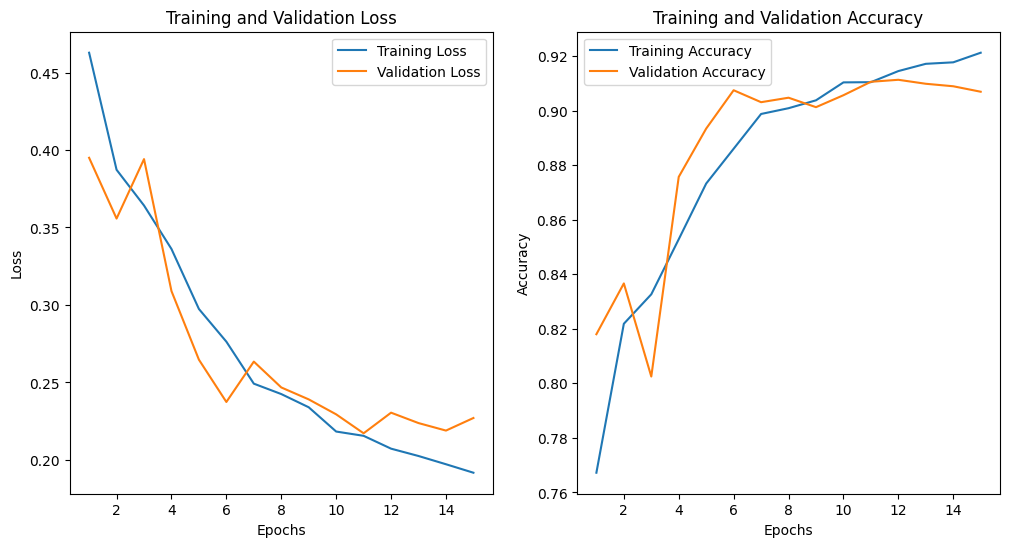

In [31]:
import matplotlib.pyplot as plt

# Access the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [32]:
fusion_model.save('models/detector_combined.h5', overwrite=False)

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

# Make predictions
predictions = fusion_model.predict(X_test)



172/172 [==============================] - 7s 37ms/step


In [34]:
y_test  = y_test.reshape(-1).astype(np.int32)
predictions = np.round(predictions.reshape(-1))

In [35]:
pd.Series(predictions).unique()

array([1., 0.], dtype=float32)

In [36]:
# Compute confusion matrix
confusion_matrix(y_test, predictions)



array([[3482,  133],
       [ 377, 1486]], dtype=int64)

In [38]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      3615
           1       0.92      0.80      0.85      1863

    accuracy                           0.91      5478
   macro avg       0.91      0.88      0.89      5478
weighted avg       0.91      0.91      0.91      5478



In [39]:
from keras.models import load_model, Model
trained_lstm = load_model('models/detector_combined.h5')

In [55]:
for l in trained_lstm.layers[:-3]:
    l.trainable = False

In [58]:
N_Model = Model(trained_lstm.input, trained_lstm.layers[-4].output)

In [60]:
fusion_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 10, 34)]          0         
                                                                 
 lstm (LSTM)                 (None, 10, 64)            25344     
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 10, 256)           394240    
                                                                 
 dense_1 (Dense)             (None, 10, 256)           65792     
                                                                 
 flatten_2 (Flatten)         (None, 2560)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               131123

In [42]:
trained_lstm.output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_3')>